In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount("/content/drive")
# Set the folder path
%cd 'drive/My Drive/Deep learning text analytics'

Mounted at /content/drive
/content/drive/My Drive/Deep learning text analytics


In [3]:
train = pd.read_csv("Data/Corona_NLP_train.csv",encoding='latin1')
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
test = pd.read_csv("Data/Corona_NLP_test.csv",encoding='latin1')
test

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [5]:
import numpy as np
import re
from gensim.parsing.preprocessing import remove_stopwords, strip_non_alphanum, strip_punctuation, strip_multiple_whitespaces
from nltk.stem import WordNetLemmatizer, PorterStemmer
import pickle
import ast
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
import nltk
nltk.download('wordnet')

# Auxiliary function used to stemming and lemmatization each token
def lem_stem_w(w):
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(w, pos='n'))
def lem_stem_s(x):
    result = ""
    # lowercase and tokenizes text
    for token in simple_preprocess(x):
        # for each token, using lem_stem_w function to lem and stem
        result += lem_stem_w(token) +" "
    return result

def norm_text(x):
    x = re.sub('[0-9]', '', str(x)) # Remove the link like text
    x = re.sub(r"http\S+", "", x)
    x = remove_stopwords(x) # Remove stopwords
    x = strip_non_alphanum(x) # Remove not an ASCII letter or digits
    x = strip_punctuation(x) # Remove punctutations
    x = strip_multiple_whitespaces(x) # Remove repeating whitespace characters
    return x

# clean and convert to dictionary
def transform(df):
    df['Tweet'] = None # Create new column
    df['Tweet'] = df['OriginalTweet'].apply(lambda x: norm_text(x)) # Normalize text from column "norm_contraction"
    df['Tweet'] = df['Tweet'].apply(lambda x: lem_stem_s(x)) # Stemming and lemmatization text
    return df

train_clean = transform(train)
train_clean = train_clean[["Tweet","Sentiment"]]

test_clean = transform(test)
test_clean = test_clean[["Tweet","Sentiment"]]

train_clean

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Tweet,Sentiment
0,menyrbi phil gahan chrisitv,Neutral
1,advic talk neighbour famili exchang phone numb...,Positive
2,coronaviru australia woolworth elderli disabl ...,Positive
3,my food stock empti pleas don panic there will...,Positive
4,me readi supermarket covid outbreak not parano...,Extremely Negative
...,...,...
41152,airlin pilot offer stock supermarket shelf nz ...,Neutral
41153,respons complaint provid cite covid relat dela...,Extremely Negative
41154,you know itâ get tough kameronwild ration toil...,Positive
41155,is wrong smell hand sanit start turn on corona...,Neutral


In [6]:
import pandas as pd
sentiment_train_integer = pd.Series(train_clean["Sentiment"]).astype('category').cat.codes.values
sentiment_test_integer = pd.Series(test_clean["Sentiment"]).astype('category').cat.codes.values
print("Number of classes",len(list(set(sentiment_train_integer))))
print("Number of classes",len(list(set(sentiment_test_integer))))

Number of classes 5
Number of classes 5


In [7]:
sentiment_dic = {}
for x in range(len(sentiment_train_integer)):
  if sentiment_train_integer[x] not in sentiment_dic:
    sentiment_dic[sentiment_train_integer[x]] = train_clean["Sentiment"][x]
sentiment_dic

{0: 'Extremely Negative',
 1: 'Extremely Positive',
 2: 'Negative',
 3: 'Neutral',
 4: 'Positive'}

In [8]:
# 2. Use the keras tokenize textual input into integer sequences.
%tensorflow_version 1.x
from tensorflow import keras
list_train = [each_string.lower() for each_string in train_clean["Tweet"]]
list_test = [each_string.lower() for each_string in test_clean["Tweet"]]
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(list_train+list_test)
vocab=tokenizer.word_index
train_text = tokenizer.texts_to_sequences(train_clean["Tweet"])
test_text = tokenizer.texts_to_sequences(test_clean["Tweet"])
print(len(vocab))

TensorFlow 1.x selected.
43160


In [9]:
# 3. Pad your sequences using the keras preprocessing tools.
import tensorflow as tf
train_array = tf.keras.preprocessing.sequence.pad_sequences(train_text,maxlen=50)
test_array  = tf.keras.preprocessing.sequence.pad_sequences(test_text,maxlen=50)

In [10]:
train_array.shape

(41157, 50)

## 1. CNN (LeNet-5)

In [11]:
%tensorflow_version 1.x
from keras.layers import concatenate
from tensorflow.python.framework.ops import disable_eager_execution
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Activation, Lambda, Input, merge, Flatten
from keras.layers import Embedding
from keras import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
import sklearn.metrics as metrics
from keras.utils.np_utils import to_categorical
disable_eager_execution()

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Embedding(len(vocab) + 1, 300, input_length=50)) 
model.add(Conv1D(256, 5, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(128, 5, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(64, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(BatchNormalization())  
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

one_hot_labels = to_categorical(sentiment_train_integer, num_classes=5) 
model.fit(train_array, one_hot_labels,epochs=10, batch_size=800)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/10
41157/41157 [==============================] - 10s 251us/step - loss: 1.3600 - accuracy: 0.4039
Epoch 2/10
41157/41157 [==============================] - 2s 59us/step - loss: 0.6253 - accuracy: 0.7688
Epoch 3/10
41157/41157 [==============================] - 2s 58us/step - loss: 0.1987 - accuracy: 0.9381
Epoch 4/10
41157/41157 [==============================] - 2s 59us/step - loss: 0.0625 - accuracy: 0.9845
Epoch 5/10
41157/41157 [==============================] - 2s 59us/step - loss: 0.0240 - accuracy: 0.9956
Epoch 6/10
41157/41157 [==============================] - 2s 59us/step - loss: 0.0138 - accuracy: 0.9985
Epoch 7/10
41157/41157 [==============================] - 2s 59us/step - loss: 0.0088 - accuracy: 0.9990
Epoch 8/10
41157/41157 [==============================] - 2s 59us/step - loss: 0.0060 - accuracy: 0.9993
Epoch 9/10
41157/41157 [==============================] - 2s 60us/step - lo

In [13]:
y_predict = model.predict_classes(test_array) 
y_predict

array([0, 4, 1, ..., 3, 0, 4])

In [14]:
print('Accuracy', metrics.accuracy_score(sentiment_test_integer, y_predict))
print('F1-score:', metrics.f1_score(sentiment_test_integer, y_predict, average='weighted'))

Accuracy 0.5642443391258557
F1-score: 0.564548089626716


## 2. TextCNN

In [15]:
main_input = Input(shape=(50,), dtype='float64')
embedder = Embedding(len(vocab) + 1, 300, input_length=50, trainable=False)
embed = embedder(main_input)
cnn1 = Conv1D(256, 3, padding='same', strides=1, activation='relu')(embed)
cnn1 = MaxPooling1D(pool_size=38)(cnn1)
cnn2 = Conv1D(256, 4, padding='same', strides=1, activation='relu')(embed)
cnn2 = MaxPooling1D(pool_size=37)(cnn2)
cnn3 = Conv1D(256, 5, padding='same', strides=1, activation='relu')(embed)
cnn3 = MaxPooling1D(pool_size=36)(cnn3)
cnn = concatenate([cnn1, cnn2, cnn3], axis=-1)
flat = Flatten()(cnn)
drop = Dropout(0.1)(flat)
dense = Dense(64, activation='relu')(drop)
dense2 = Dense(32, activation='relu')(dense)
batch = BatchNormalization()(dense2)
main_output = Dense(5, activation='softmax')(batch)
model = Model(inputs=main_input, outputs=main_output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_array, one_hot_labels,epochs=10, batch_size=800)

Epoch 1/10
41157/41157 [==============================] - 5s 115us/step - loss: 1.5451 - accuracy: 0.2930
Epoch 2/10
41157/41157 [==============================] - 4s 102us/step - loss: 1.3993 - accuracy: 0.4001
Epoch 3/10
41157/41157 [==============================] - 4s 102us/step - loss: 1.2064 - accuracy: 0.5199
Epoch 4/10
41157/41157 [==============================] - 4s 102us/step - loss: 0.9254 - accuracy: 0.6550
Epoch 5/10
41157/41157 [==============================] - 4s 103us/step - loss: 0.6899 - accuracy: 0.7479
Epoch 6/10
41157/41157 [==============================] - 4s 103us/step - loss: 0.5684 - accuracy: 0.7851
Epoch 7/10
41157/41157 [==============================] - 4s 104us/step - loss: 0.5013 - accuracy: 0.8082
Epoch 8/10
41157/41157 [==============================] - 4s 103us/step - loss: 0.4635 - accuracy: 0.8193
Epoch 9/10
41157/41157 [==============================] - 4s 103us/step - loss: 0.4447 - accuracy: 0.8241
Epoch 10/10
41157/41157 [=====================

In [16]:
y_predict = model.predict(test_array) 
y_predict = np.argmax(y_predict,axis=1)

In [17]:
print('Accuracy', metrics.accuracy_score(sentiment_test_integer, y_predict))
print('F1-score:', metrics.f1_score(sentiment_test_integer, y_predict, average='weighted'))

Accuracy 0.30858346498156924
F1-score: 0.2979352817579396


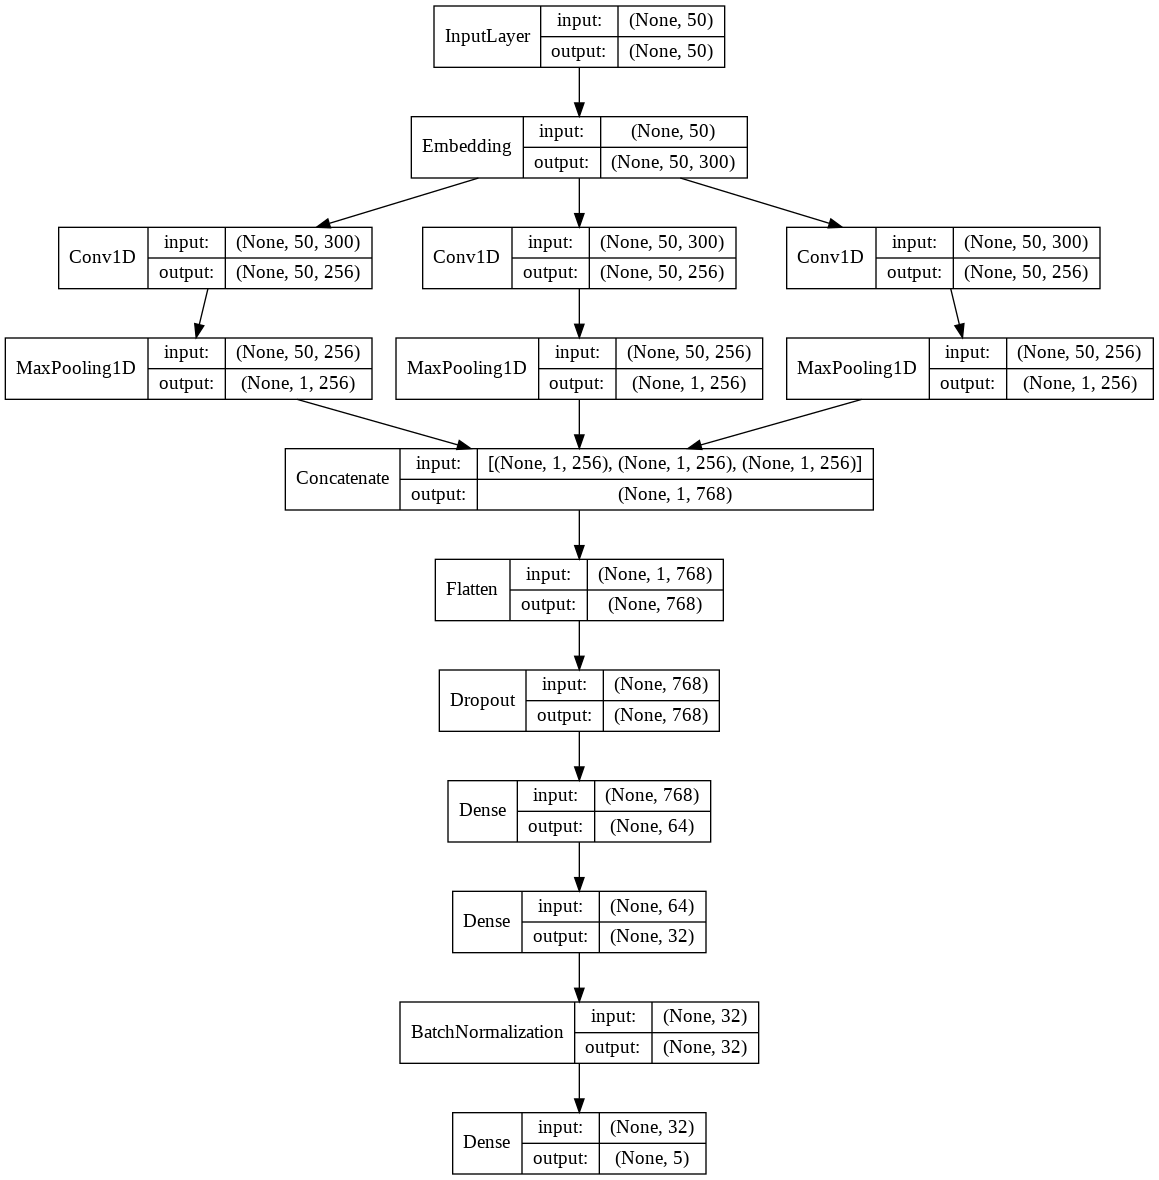

In [18]:
from keras.utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=False)

## 3. Char-CNN

In [33]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level = True)
tokenizer.fit_on_texts(list_train+list_test)
vocab=tokenizer.word_index
train_text = tokenizer.texts_to_sequences(train_clean["Tweet"])
test_text = tokenizer.texts_to_sequences(test_clean["Tweet"])
train_array = tf.keras.preprocessing.sequence.pad_sequences(train_text,maxlen=150)
test_array  = tf.keras.preprocessing.sequence.pad_sequences(test_text,maxlen=150)

In [34]:
model = Sequential()
model.add(Embedding(len(vocab) + 1, 1000, input_length=150)) 
model.add(Conv1D(256, 7, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(256, 7, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(256, 3, padding='same'))
model.add(Conv1D(256, 3, padding='same'))
model.add(Conv1D(256, 3, padding='same'))
model.add(Conv1D(256, 3, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization()) 
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

one_hot_labels = to_categorical(sentiment_train_integer, num_classes=5)  
model.fit(train_array, one_hot_labels,epochs=10, batch_size=800)

Epoch 1/10
41157/41157 [==============================] - 20s 489us/step - loss: 1.7532 - accuracy: 0.2670
Epoch 2/10
41157/41157 [==============================] - 16s 398us/step - loss: 1.5408 - accuracy: 0.2927
Epoch 3/10
41157/41157 [==============================] - 16s 386us/step - loss: 1.4902 - accuracy: 0.3186
Epoch 4/10
41157/41157 [==============================] - 16s 380us/step - loss: 1.4286 - accuracy: 0.3581
Epoch 5/10
41157/41157 [==============================] - 16s 380us/step - loss: 1.3607 - accuracy: 0.3966
Epoch 6/10
41157/41157 [==============================] - 16s 382us/step - loss: 1.2662 - accuracy: 0.4468
Epoch 7/10
41157/41157 [==============================] - 16s 387us/step - loss: 1.1462 - accuracy: 0.5050
Epoch 8/10
41157/41157 [==============================] - 16s 387us/step - loss: 1.0424 - accuracy: 0.5581
Epoch 9/10
41157/41157 [==============================] - 16s 384us/step - loss: 0.9117 - accuracy: 0.6147
Epoch 10/10
41157/41157 [============

In [35]:
y_predict = model.predict_classes(test_array)
y_predict

array([0, 1, 1, ..., 2, 1, 1])

In [36]:
print('Accuracy', metrics.accuracy_score(sentiment_test_integer, y_predict))
print('F1-score:', metrics.f1_score(sentiment_test_integer, y_predict, average='weighted'))

Accuracy 0.3723012111637704
F1-score: 0.3477960931356289


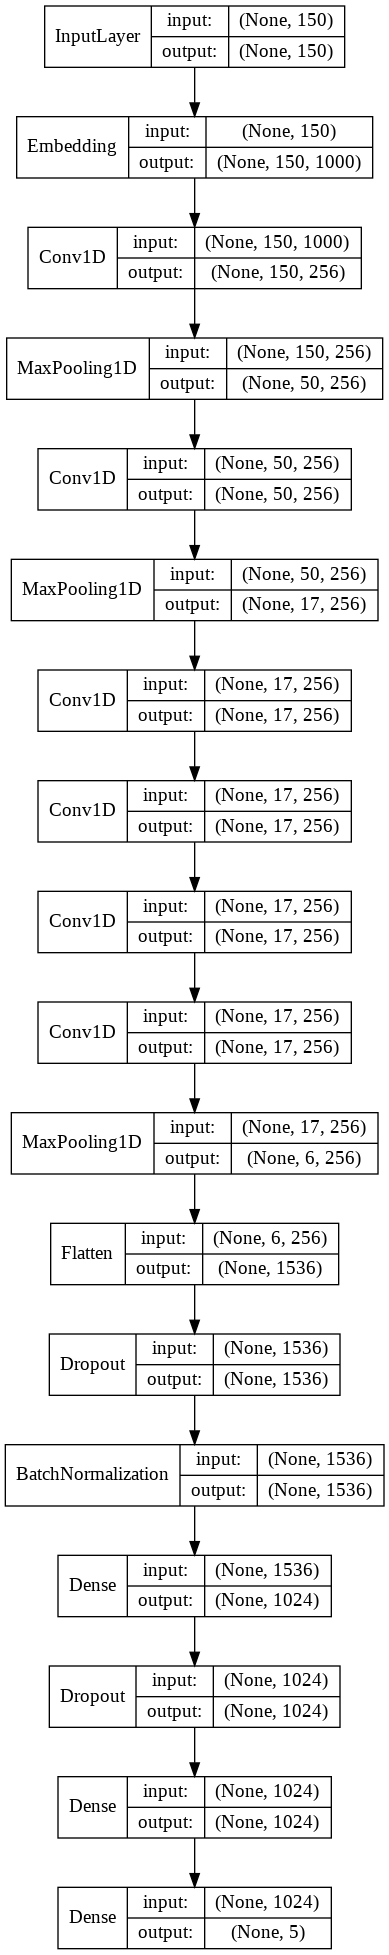

In [37]:
from keras.utils import plot_model
plot_model(model,to_file='model2.png',show_shapes=True,show_layer_names=False)